Unzip the dataset copressed files in dataset. They are divided in speech and song.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import librosa
from tqdm.notebook import tqdm
from IPython.display import Audio
from pandas.api.types import is_numeric_dtype

TS_DATASET_FOLDER = os.path.join("..", "dataset")
SONG_DATASET_FOLDER = os.path.join(TS_DATASET_FOLDER,"Audio_Song_Actors_01-24")
SPEECH_DATASET_FOLDER = os.path.join(TS_DATASET_FOLDER,"Audio_Speech_Actors_01-24")

def get_actor_files(vc, actor_n):
    fold = SONG_DATASET_FOLDER if vc == "song" else SPEECH_DATASET_FOLDER
    act_fold = f"Actor_{str(actor_n).zfill(2)}"
    fold = os.path.join(fold, act_fold )
    return [os.path.join(fold,f) for f in os.listdir(fold) if f.endswith(".wav")]


CATEGORICAL_FEATURES_NAMES = {
    "modality": {"01": "full-AV", "02": "video-only", "03": "audio-only"}, 
    "vocal_channel": {"01": "speech", "02": "song"},
    "emotion": {"01" : "neutral", "02" : "calm", "03" : "happy", "04" : "sad", "05" : "angry", "06" : "fearful", "07" : "disgust", "08" : "surprised"},
    "emotional_intensity": {"01" : "normal", "02" : "strong"},
    "statement": {"01" : "kids", "02" : "dogs"},
    "repetition": {"01" : "1st", "02" : "2nd"},
    "actor": {str(i).zfill(2): str(i).zfill(2) for i in range(1, 25)}
}

SAMPLING_RATE = 48_000
DECIMATION_FACTOR = 8

def recompute_numeric_categorical(df):
    global numerical_attr_list, categorical_attr_list
    numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
    categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

    

# File import
Files must be downsampled before being saved in memory because they are enormous (200_000 floating point numbers, roughly 0.5 MB)

In [2]:
import sys
from scipy.signal import decimate

df = pd.DataFrame(columns = list(CATEGORICAL_FEATURES_NAMES.keys()) + ["audio_trace", "path"])
for vc in ["speech", "song"]:
    for actor_n in tqdm(range(1,5)):
        for f in get_actor_files(vc, actor_n):
            segment, sr = librosa.load(f, sr=None)
            segment = decimate(segment, q=DECIMATION_FACTOR)

            categ_values = str(os.path.basename(f)).strip(".wav").split("-")

            row = {attr:val for attr, val in zip(CATEGORICAL_FEATURES_NAMES.keys(), categ_values)}
            row["audio_trace"] = [segment]
            row["path"] = f
            row = pd.DataFrame(row, index = [0])
            df = pd.concat([df,  row], ignore_index=True)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
for column in df.columns:
    df = df.replace(CATEGORICAL_FEATURES_NAMES)

df["sex"] = ["F" if i % 2 == 0 else "M" for i in df["actor"].astype(int)]
df = df.replace({ "actor": {str(i).zfill(2): f"actor_{str(i).zfill(2)}" for i in range(1, 25)}})
df = df.drop(columns = ["modality"])
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,audio_trace,path,sex
0,speech,happy,normal,kids,2nd,actor_01,"[6.7432594e-11, -1.7281297e-10, 2.6411556e-10,...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M
1,speech,calm,strong,dogs,2nd,actor_01,"[-5.096353e-09, 7.548913e-09, -8.45547e-09, 6....",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M
2,speech,fearful,normal,kids,2nd,actor_01,"[0.00011891391, 0.00010525208, 6.3990985e-05, ...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M
3,speech,neutral,normal,kids,2nd,actor_01,"[-2.9781221e-08, -1.4013209e-06, -1.0139452e-0...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M
4,speech,calm,normal,kids,1st,actor_01,"[3.0153627e-05, -4.7941107e-06, 1.3743208e-06,...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M


## Preprocessing

Now check whether a linear trend is present

In [4]:
from sklearn.linear_model import LinearRegression
coeffs, intercepts = [], []
for trace in df.audio_trace:
    subsamp_trace = decimate(trace, q=8)
    model = LinearRegression()
    model.fit(np.arange(len(subsamp_trace)).reshape(-1,1), subsamp_trace)
    coeffs.append(model.coef_)
    intercepts.append(model.intercept_)
print(np.mean(coeffs), np.mean(intercepts))

-8.298474287571662e-11 -1.4550812956706328e-07


In [5]:
from scipy.signal import detrend
detrended_traces = pd.DataFrame(columns=["detrended_trace"])
for trace in df.audio_trace:
    row = dict(detrended_trace=[detrend(trace)])
    row = pd.DataFrame(row, index=[0])
    detrended_traces = pd.concat([detrended_traces, row], ignore_index=True)
df = df.join(detrended_traces)

Now rescale all

In [6]:
normalized_traces = pd.DataFrame(columns = ["normalized_trace"])
for det_trace in df.detrended_trace:
    row = dict(normalized_trace=[(det_trace - np.mean(det_trace))/np.std(det_trace)])
    row = pd.DataFrame(row, index=[0])
    normalized_traces = pd.concat([normalized_traces, row], ignore_index=True)

df = df.join(normalized_traces)

now clean noise using a moving mean filter

In [7]:
try:
    df.drop(columns=["denoised_trace"], inplace=True)
except KeyError as e:
    pass
denoised_traces = pd.DataFrame(columns=["denoised_trace"])
window=20
for norm_trace in df.normalized_trace:
    row = pd.DataFrame([[np.convolve(norm_trace, np.ones(window)/window, mode='valid')]], index=[0], columns=["denoised_trace"])
    denoised_traces = pd.concat([denoised_traces, row], ignore_index=True)
df = df.join(denoised_traces)
recompute_numeric_categorical(df)

now check the difference in terms of perceived audio

In [8]:
Audio(df.audio_trace[58], rate=SAMPLING_RATE/DECIMATION_FACTOR)

In [9]:
Audio(df.denoised_trace[51], rate=SAMPLING_RATE/DECIMATION_FACTOR)

In [10]:
# from tslearn.metrics import dtw 
# ts1 ,ts2 = decimate(df.loc[0, "normalized_trace"], q=1),decimate(df.loc[1, "normalized_trace"], q=1)
# print(dtw(ts1,ts2))

In [11]:
print(f"dataset size is {sys.getsizeof(df)/1e6} MB")

dataset size is 123.53438 MB


Let's see if it is feasible to trim silences before and after the phrase

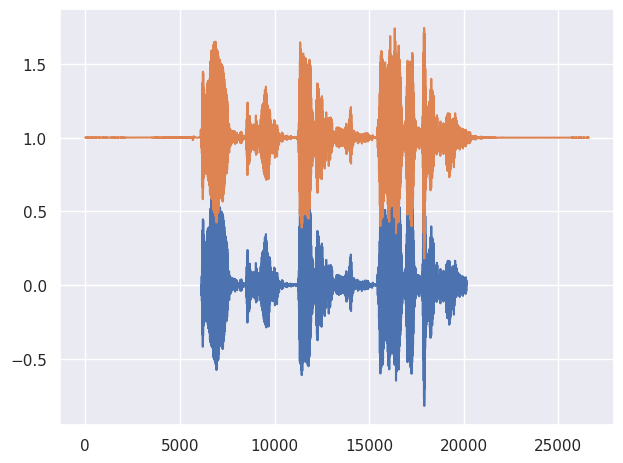

In [12]:
def trim_silence(track, window_in_ms=10.0, rel_thr=1e-2):
    ts = pd.Series(track)
    window = int(window_in_ms*1e-3*SAMPLING_RATE/DECIMATION_FACTOR )
    rolling_std = ts.rolling(window=window).std()
    mask = rolling_std > rel_thr*rolling_std.max()
    begin, end = np.where(mask)[0][0], np.where(mask)[0][-1]
    return track[begin:end], begin, end

trimmed, begin, end = trim_silence(df["denoised_trace"][50],  rel_thr=5e-2)
plt.plot(np.arange(begin, end), trimmed)
plt.plot(df["denoised_trace"][50] + 1)

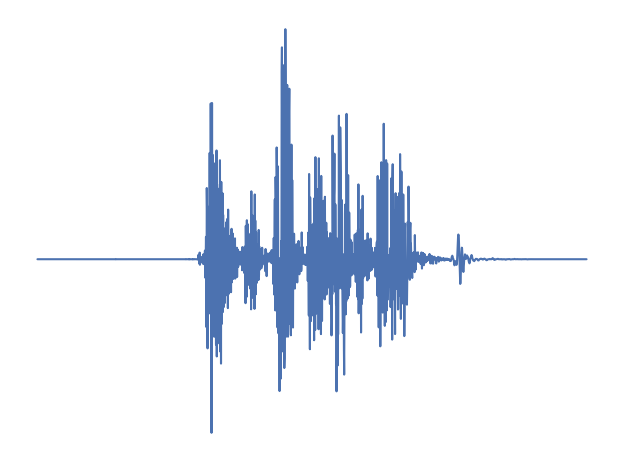

In [13]:
plt.plot(df.audio_trace[0] [::10])
plt.axis("off")
plt.savefig("trace.pdf")

So it seems to work. Now add to the dataset the trimmed tracks

In [14]:
trimmed_df = pd.DataFrame(columns=["trimmed_trace", "begin_s", "end_s"])
for den_track in df.denoised_trace:
    trimmed, begin, end = trim_silence(den_track, rel_thr=5e-2)
    row = dict( trimmed_trace=[trimmed], 
                begin_s=begin/SAMPLING_RATE*DECIMATION_FACTOR, 
                end_s=end/SAMPLING_RATE*DECIMATION_FACTOR)
    row = pd.DataFrame(row, index=[0])
    trimmed_df = pd.concat([trimmed_df, row], ignore_index=True)

try:
    df.drop(columns=["trimmed_trace", "begin_s", "end_s"], inplace=True)
except KeyError as e:
    print(e)
    pass

df = df.join(trimmed_df)

"['trimmed_trace', 'begin_s', 'end_s'] not found in axis"


check if the distribution of start time/ end time is related to actors' reactivity

In [ ]:
sns.kdeplot(data =df, x="begin_s", hue="actor", legend=False);


So it seems that the reactivity of the actors is roughly one second.

## Phonetic traces
Let's call the phonetic traces of the track the corase-grained properties of the audio track, that could correspond for example to the glottological properties of the sound particle(fricative, nasal, plosive, etc).
Check if there is some sort of difference between the "kids" statement and the "dogs" statement, even if they are rythmically equivalent.

Maybe a good starting point could be the clustering of the tracks using dtw distance on these coarse-grained timeseries.

1754


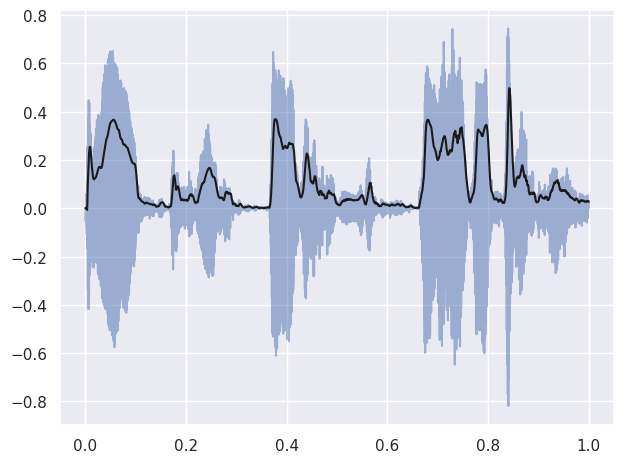

In [16]:
window_in_ms = 10.0 # Big window, is it coherent with the timescale of sound particles?
window = int(window_in_ms*1e-3*SAMPLING_RATE/DECIMATION_FACTOR )
track_N = 50

rolled_signal = pd.Series(df.trimmed_trace[track_N]).rolling(window=window).std().fillna(0)
phonetic_signal = decimate(rolled_signal,q=8) #GIGA downsampling
print(len(phonetic_signal))
plt.plot(np.linspace(0,1,len(df.trimmed_trace[track_N])), df.trimmed_trace[track_N], alpha=0.5)
plt.plot(np.linspace(0,1,len(phonetic_signal)), phonetic_signal, color="k")


clearly the timeseries must be renormalized. I choose a minmaxscaler.

In [17]:
def get_window_from_ms(window_in_ms, true_sampling_rate):
    return int(window_in_ms*1e-3*true_sampling_rate )
window = get_window_from_ms(10.0, SAMPLING_RATE/DECIMATION_FACTOR )
downsampling_factor = 8

phonetic_traces = pd.DataFrame(columns=["phonetic_trace"])
ph_traces_lengths = []

for trim_trace in df.trimmed_trace:
    rolled_signal = pd.Series(trim_trace).rolling(window=window).std().fillna(0)
    phonetic_signal = decimate(rolled_signal,q=downsampling_factor)
    ph_traces_lengths.append(len(phonetic_signal))
    row = pd.DataFrame([[phonetic_signal]],columns=["phonetic_trace"], index=[0])
    phonetic_traces = pd.concat([phonetic_traces, row], ignore_index=True)
    
try:
    df.drop(columns=["phonetic_trace"], inplace=True)
except KeyError as e:
    print(e)
    pass

df = df.join(phonetic_traces)
recompute_numeric_categorical(df)

"['phonetic_trace'] not found in axis"


In [18]:
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,audio_trace,path,sex,detrended_trace,normalized_trace,denoised_trace,trimmed_trace,begin_s,end_s,phonetic_trace
0,speech,happy,normal,kids,2nd,actor_01,"[6.7432594e-11, -1.7281297e-10, 2.6411556e-10,...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[-1.0094078e-06, -1.0095991e-06, -1.0091135e-0...","[-0.00012356308, -0.0001235865, -0.00012352705...","[-0.00012349906683084555, -0.00012353216297924...","[0.16673281434923412, 0.16682422775775194, 0.1...",1.056000,2.753833,"[0.007309162743024048, -0.005967321597070268, ..."
1,speech,calm,strong,dogs,2nd,actor_01,"[-5.096353e-09, 7.548913e-09, -8.45547e-09, 6....",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[-1.817036e-06, -1.8043341e-06, -1.820282e-06,...","[-0.00055798586, -0.00055408524, -0.0005589826...","[-0.0005577115487540141, -0.000554263230878859...","[-0.11201764894649387, -0.1356520767323673, -0...",1.022167,2.955167,"[0.0023068449603544615, -0.002000297799337692,..."
2,speech,fearful,normal,kids,2nd,actor_01,"[0.00011891391, 0.00010525208, 6.3990985e-05, ...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[0.000118794975, 0.00010513312, 6.3871994e-05,...","[0.012991183, 0.01149715, 0.006984915, -0.0020...","[-0.0014758842002265734, -0.002106528289186826...","[0.06298788029234856, 0.09211182433646173, 0.1...",1.053333,2.659500,"[0.003728912078991345, -0.0029744810335230617,..."
3,speech,neutral,normal,kids,2nd,actor_01,"[-2.9781221e-08, -1.4013209e-06, -1.0139452e-0...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[-7.634266e-07, -2.1349633e-06, -1.0873091e-05...","[-0.00018139722, -0.00050728547, -0.0025835356...","[-0.00068194866853446, -0.0006825281869168975,...","[-0.24369214102625852, -0.26837380863726146, -...",1.063833,2.306833,"[0.007655365869838064, -0.004895776745141541, ..."
4,speech,calm,normal,kids,1st,actor_01,"[3.0153627e-05, -4.7941107e-06, 1.3743208e-06,...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[2.960676e-05, -5.3410026e-06, 8.274048e-07, -...","[0.010191605, -0.0018385442, 0.00028482106, -0...","[0.00020696830306405907, -0.000329079943367105...","[-0.22643456608057022, -0.24182620048522951, -...",1.086000,2.554833,"[0.003198363173483212, -0.0009467218998658714,..."


Now standardise the length of the phonetic_signal. This is done by mapping each array in a fixed-length array. This length M is chosen to be the minimum of the lengths.
The map is done by selecting uniformly M integers from the interval (0, len(trace))

In [19]:
from sklearn.preprocessing import MinMaxScaler

time_rescale  = True
if time_rescale:
    std_len = min(2000, np.min(ph_traces_lengths))
    print(f"standard_lenght is set to {std_len}")
    
standardised_phonetic_traces = pd.DataFrame(columns=["std_phon_trace", "t_rescale_factor"])
for tr,trimmed_tr in zip(df.phonetic_trace,df.trimmed_trace):
    
    # Generates the downsampling indexes
    if time_rescale:
        indexes = (len(tr)-1)*(np.linspace(0,1,std_len))
        indexes = indexes.astype(int)
        time_rescale_factor = len(trimmed_tr)/std_len

        # Check repeated values
        indexes, counts = np.unique(indexes, return_counts=True)
        if (counts>1).any():
            print("repeated index")
    else:
        indexes = np.arange(len(tr))
        
    # Scales the signal here
    phonetic_signal = MinMaxScaler().fit_transform(tr[indexes].reshape(-1,1)).reshape(-1)
    row = pd.DataFrame([[phonetic_signal, time_rescale_factor]], columns=["std_phon_trace", "t_rescale_factor"], index=[0])
    standardised_phonetic_traces = pd.concat([standardised_phonetic_traces, row], ignore_index=True)

try:
    df.drop(columns=["std_phon_trace", "t_rescale_factor"], inplace=True)
except KeyError as e:
    print(e)
    pass

df = df.join(standardised_phonetic_traces)
recompute_numeric_categorical(df)

standard_lenght is set to 844
"['std_phon_trace', 't_rescale_factor'] not found in axis"


In [20]:
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,audio_trace,path,sex,detrended_trace,normalized_trace,denoised_trace,trimmed_trace,begin_s,end_s,phonetic_trace,std_phon_trace,t_rescale_factor
0,speech,happy,normal,kids,2nd,actor_01,"[6.7432594e-11, -1.7281297e-10, 2.6411556e-10,...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[-1.0094078e-06, -1.0095991e-06, -1.0091135e-0...","[-0.00012356308, -0.0001235865, -0.00012352705...","[-0.00012349906683084555, -0.00012353216297924...","[0.16673281434923412, 0.16682422775775194, 0.1...",1.056000,2.753833,"[0.007309162743024048, -0.005967321597070268, ...","[0.06155830129985527, 0.04844308688474689, 0.0...",12.069905
1,speech,calm,strong,dogs,2nd,actor_01,"[-5.096353e-09, 7.548913e-09, -8.45547e-09, 6....",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[-1.817036e-06, -1.8043341e-06, -1.820282e-06,...","[-0.00055798586, -0.00055408524, -0.0005589826...","[-0.0005577115487540141, -0.000554263230878859...","[-0.11201764894649387, -0.1356520767323673, -0...",1.022167,2.955167,"[0.0023068449603544615, -0.002000297799337692,...","[0.01802963831205854, 0.014090682763118752, 0....",13.741706
2,speech,fearful,normal,kids,2nd,actor_01,"[0.00011891391, 0.00010525208, 6.3990985e-05, ...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[0.000118794975, 0.00010513312, 6.3871994e-05,...","[0.012991183, 0.01149715, 0.006984915, -0.0020...","[-0.0014758842002265734, -0.002106528289186826...","[0.06298788029234856, 0.09211182433646173, 0.1...",1.053333,2.659500,"[0.003728912078991345, -0.0029744810335230617,...","[0.021129239605034822, 0.012803019981685388, 0...",11.418246
3,speech,neutral,normal,kids,2nd,actor_01,"[-2.9781221e-08, -1.4013209e-06, -1.0139452e-0...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[-7.634266e-07, -2.1349633e-06, -1.0873091e-05...","[-0.00018139722, -0.00050728547, -0.0025835356...","[-0.00068194866853446, -0.0006825281869168975,...","[-0.24369214102625852, -0.26837380863726146, -...",1.063833,2.306833,"[0.007655365869838064, -0.004895776745141541, ...","[0.05180386164238933, 0.04374689812154823, 0.0...",8.836493
4,speech,calm,normal,kids,1st,actor_01,"[3.0153627e-05, -4.7941107e-06, 1.3743208e-06,...",../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,"[2.960676e-05, -5.3410026e-06, 8.274048e-07, -...","[0.010191605, -0.0018385442, 0.00028482106, -0...","[0.00020696830306405907, -0.000329079943367105...","[-0.22643456608057022, -0.24182620048522951, -...",1.086000,2.554833,"[0.003198363173483212, -0.0009467218998658714,...","[0.03317946076119785, 0.03033992199656451, 0.0...",10.441943


## Division in syllables
As a test, I try to divide the signal into adaptive windows corresponding to the syllables

- kidz-a-taw-kin-by-the-doo
- dogz-a-sit-ting-by-the-doo


In [25]:
%load_ext autoreload
%autoreload 2

from utils import PhoneticList, SyllablesDivider

Test on a toy trace

[array([0.0035    , 0.03483333, 0.06633333, 0.09766667])]


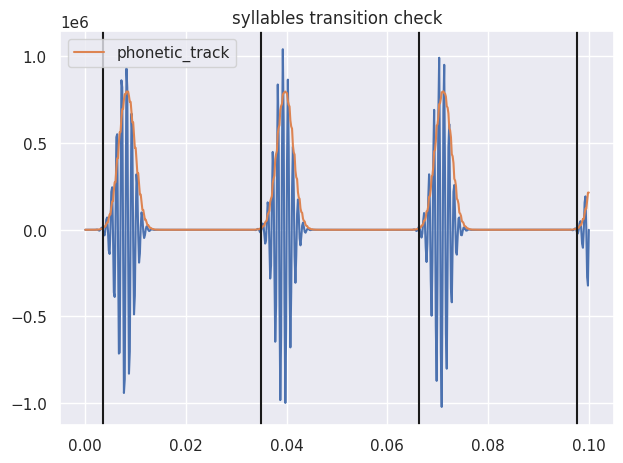

In [26]:
np.random.seed(42)

T = 0.1 # seconds
sampling_rate = 6_000 # Hz
frequency = 1_000 # Hz

time = np.linspace(0, T, int(T*sampling_rate))
test_track = (1 + np.sin(200*time))**20*np.sin(2*np.pi*frequency*time) + np.random.normal(0,0.1,size=int(T*sampling_rate))

plt.plot(time, test_track)

ph_list = PhoneticList.from_tracks([test_track], 
                                   [sampling_rate], 
                                   window_ms=1.0
                                  )
for ph_tr in ph_list.elements:
    plt.plot(ph_tr.time, ph_tr.track, label="phonetic_track")

divider = SyllablesDivider(min_size_ms=1.0, 
                           smoothing_window_ms=1.0, 
                           derivative_threshold=0.1
                          )
s_index, s_time = divider.get_start_points(ph_list, return_times=True)
print(s_time)
for st in s_time[0]:
    plt.axvline(st, color="k")

plt.legend()
plt.title("syllables transition check");


test on on some real traces

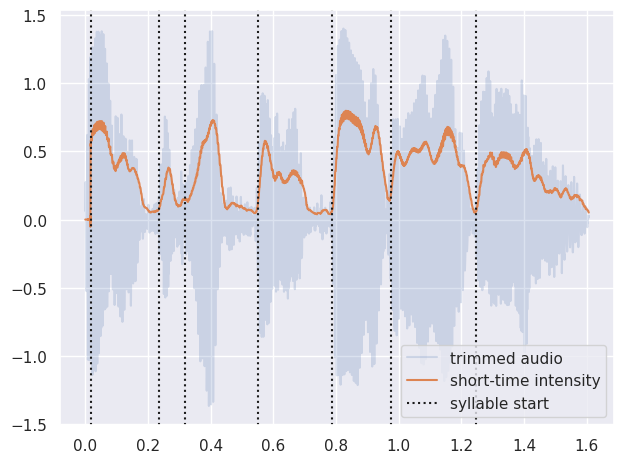

In [88]:
test_tracks = df.iloc[:10]

ph_list = PhoneticList.from_tracks(test_tracks.trimmed_trace, [SAMPLING_RATE/DECIMATION_FACTOR]*len(test_tracks), 17.0, decimate=2)
divider = SyllablesDivider(min_size_ms=8.0, 
                           smoothing_window_ms=20.0,
                           n_syllables=7,
                           #derivative_threshold=0.12
                          )

s_index, s_time = divider.get_start_points(ph_list, return_times=True)

test_track_index = 2
original_audio = test_tracks.trimmed_trace[test_track_index]
original_time = np.linspace(0, len(original_audio)/(SAMPLING_RATE/DECIMATION_FACTOR), len(original_audio))


plt.plot(original_time, original_audio, alpha=0.2, label="trimmed audio")
plt.plot(ph_list.elements[test_track_index].time,ph_list.elements[test_track_index].track, label="short-time intensity")

flag = False
for st in s_time[test_track_index]:
    plt.axvline(st, color="k", ls=":", label="syllable start" if not flag else "")
    flag=True
plt.legend()

In [89]:
first_syllable_start = []
first_syllable_end = []
syll_index = divider.get_start_points(ph_list)

for i in range(len(ph_list)):
    first_syllable_start.append(ph_list[i].get_index_in_original_audio(syll_index[i][0]))
    first_syllable_end.append(ph_list[i].get_index_in_original_audio(syll_index[i][1]))

print(first_syllable_start)
print(first_syllable_end)


[3158, 9876, 1414, 5856, 5566, 6448, 5102, 7498, 9424, 5378]
[5670, 2076, 7488, 4258, 1774, 7586, 5928, 1052, 6678, 9532]


## SAX & PAA
clearly sax is preferable

844
10187
(1, 844, 1)
(1, 844, 1)


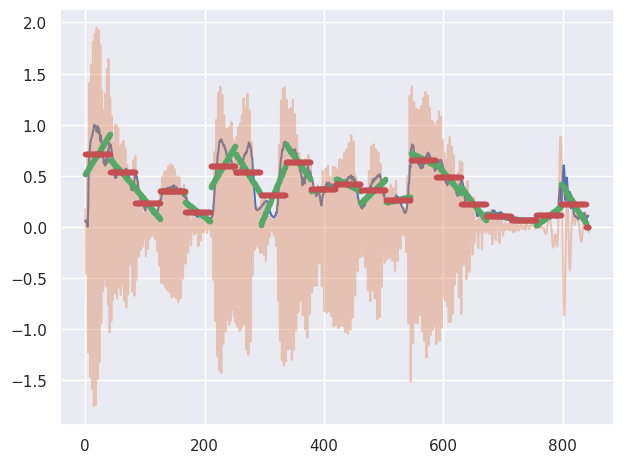

In [21]:
from tslearn.piecewise import OneD_SymbolicAggregateApproximation as SAX1d, SymbolicAggregateApproximation as SAX
from tslearn.piecewise import PiecewiseAggregateApproximation as PAA
from tslearn.utils import to_time_series_dataset

sax = SAX1d( n_segments=20,
          alphabet_size_avg=128, 
          alphabet_size_slope=128)

paa = PAA(n_segments=20)


track = df.std_phon_trace[0]
print(len(track))
plt.plot(track)
plt.plot(np.linspace(0,std_len,len(df.trimmed_trace[0])), df.trimmed_trace[0], alpha=0.4)
print(len(df.trimmed_trace[0]))
for approximator in [sax, paa]:

    reduced_track = approximator.inverse_transform(approximator.fit_transform(to_time_series_dataset(track)))
    print(reduced_track.shape)
    reduced_track = reduced_track.reshape(-1)
    plt.plot(reduced_track, ls="", marker=".")

In [22]:
Audio(df.trimmed_trace[1][:int(850*df.t_rescale_factor[1])], rate=SAMPLING_RATE/DECIMATION_FACTOR)

So each track is SAX transformed

In [23]:
sax = SAX1d( n_segments=50,
          alphabet_size_avg=64, 
          alphabet_size_slope=100)
sax_tracks = sax.fit_transform(to_time_series_dataset(df.std_phon_trace[:10]))
sax_tracks.shape

(10, 50, 2)

In [24]:
# All to all dtw distance
# from tslearn.metrics import cdist_dtw
# kids_traces = df.std_phon_trace[df.statement=="kids"].values
# dogs_traces = df.std_phon_trace[df.statement=="dogs"].values
# mat = cdist_dtw(kids_traces[:40], kids_traces[:40], global_constraint="itakura", itakura_max_slope=2, n_jobs=-1)

KeyboardInterrupt: 

In [ ]:
# plt.imshow(mat)
# plt.grid("")

In [ ]:
# df[df.statement=="kids"].reset_index().loc[:20]